# 🚀Introduction
In this kernel I will try to incorporate [wandb's sweep](https://docs.wandb.ai/sweeps) in a simple experiment. [Weights and Biases](https://wandb.ai) provides us with a lot of features which help in the reproducibility and ease of the Deep Learning experiments. One of the best feature that they provide is sweeps. Sweeps help in hyperparameter optimization with little to no boilerplate code.

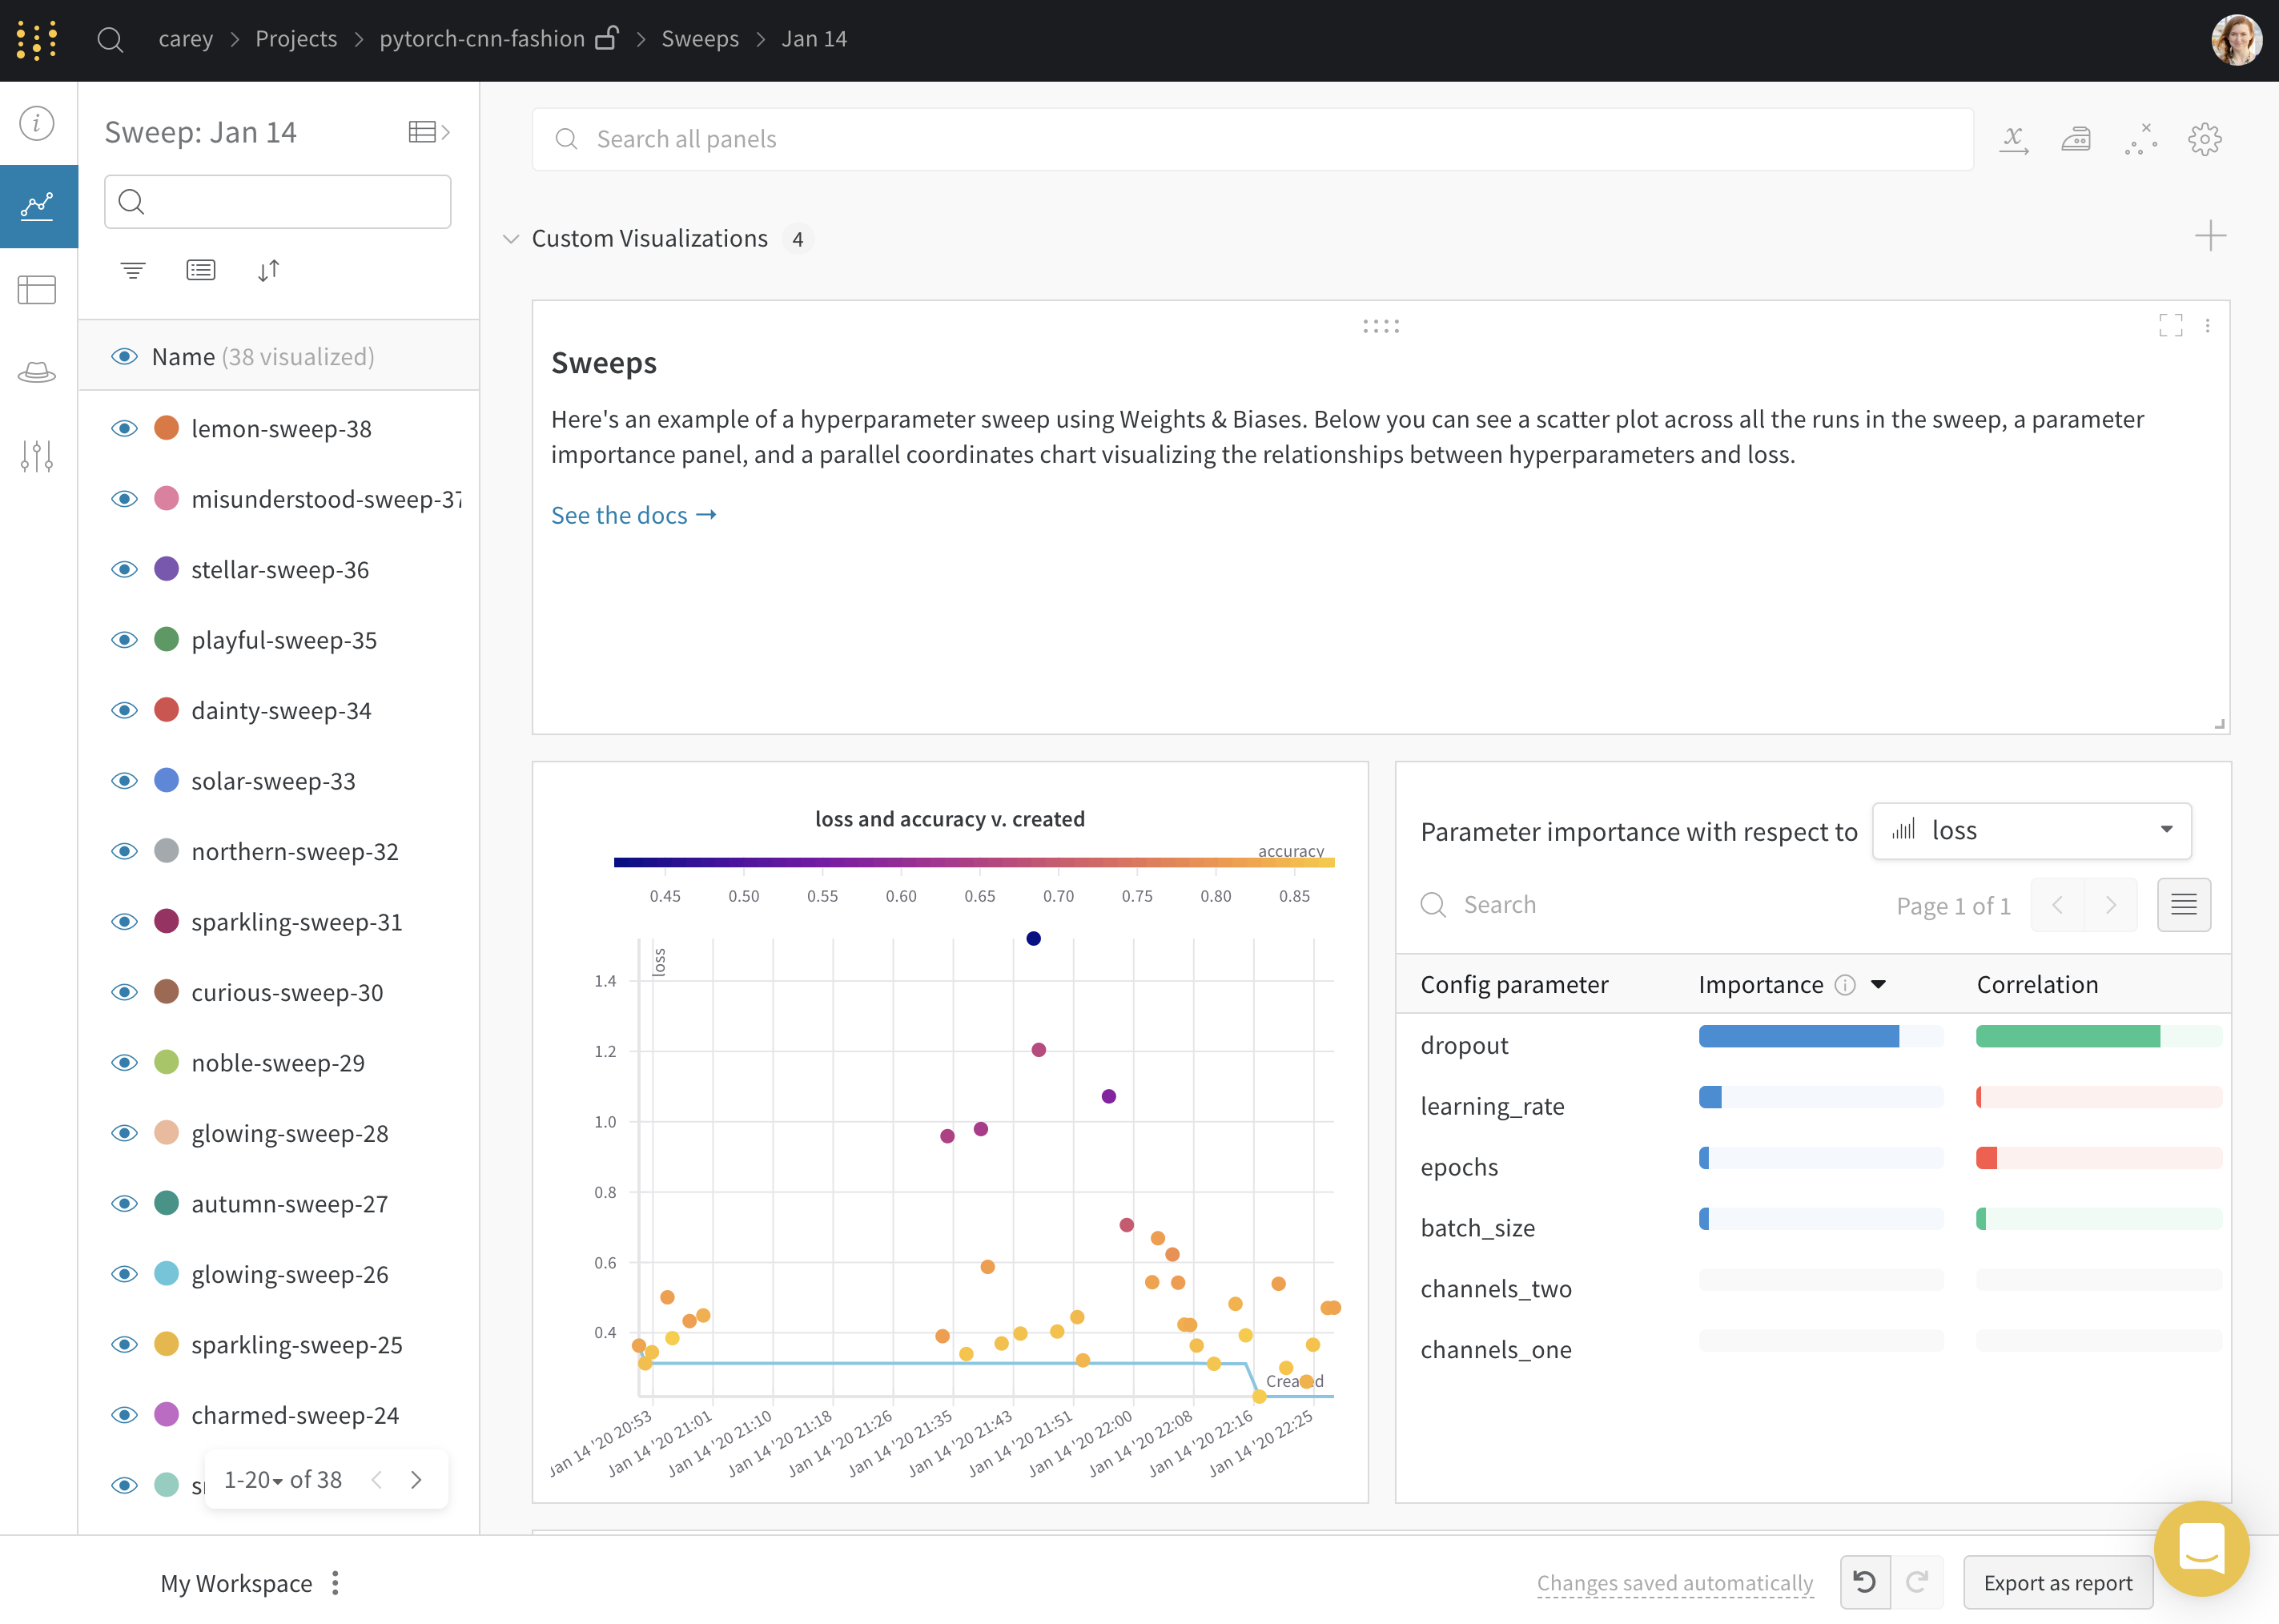

This kernel is focused towards providing a starter place to help people try out this product and help themselves with great hyperparameter optimization. Hope this helps people imbibe a better approach towards reproducible DL.

# 🖋️Imports
The following imports will be used all over this kernel:
- wandb
- pandas
- tensorflow

In [ ]:
import wandb

import pandas as pd

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

# 💾Data
The data is well organized in the folders. We will need to read the `csv` and take an `ImageDataGenerator` for the images to flow from the directory directly.

In [ ]:
DIR = '../input/cassava-leaf-disease-classification'

img_path = f'{DIR}/train_images'
df = pd.read_csv(f'{DIR}/train.csv')
df['label'] = df['label'].astype('string')

df.head()

# 🧹Sweeps

## 1. Define the Sweep

Weights & Biases sweeps give you powerful levers to configure your sweeps exactly how you want them, with just a few lines of code. The sweeps config can be defined as a dictionary or a [YAML file](https://docs.wandb.com/library/sweeps).

Let's walk through some of them together:
*   **Metric** – This is the metric the sweeps are attempting to optimize. Metrics can take a `name` (this metric should be logged by your training script) and a `goal` (maximize or minimize). 
*   **Search Strategy** – Specified using the 'method' variable. We support several different search strategies with sweeps. 
  *   **Grid Search** – Iterates over every combination of hyperparameter values.
  *   **Random Search** – Iterates over randomly chosen combinations of hyperparameter values.
  *   **Bayesian Search** – Creates a probabilistic model that maps hyperparameters to probability of a metric score, and chooses parameters with high probability of improving the metric. The objective of Bayesian optimization is to spend more time in picking the hyperparameter values, but in doing so trying out fewer hyperparameter values.
*   **Stopping Criteria** – The strategy for determining when to kill off poorly peforming runs, and try more combinations faster. We offer several custom scheduling algorithms like [HyperBand](https://arxiv.org/pdf/1603.06560.pdf) and Envelope.
*   **Parameters** – A dictionary containing the hyperparameter names, and discreet values, max and min values or distributions from which to pull their values to sweep over.

You can find a list of all configuration options [here](https://docs.wandb.com/library/sweeps/configuration).

In [ ]:
sweep_config = {
    'method': "random",
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize',
    },
    'parameters': {
        "optimizer": {
            "values": ['adam', 'sgd', 'rmsprop']
        },
        "nodes": {
            "values": [128, 256, 512]
        },
        "epochs": {
            "values": [1,2,3,5]
        },
        "learning_rate": {
            "distribution": "uniform",
            "min": 0.0001,
            "max": 0.1
        },
        "batch_size": {
            "distribution": "q_log_uniform",
            "q": 1,
            "min": 32,
            "max": 128
        },
    },
}

## 2. Initialize the sweep

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="leaf-cnn")

## 3. Define the training loop

In [ ]:
def train():
    default_config={
        "optimizer": 'adam',
        "nodes":128,
        "epochs": 1,
        "learning_rate": 1e-2,
        "batch_size": 32,}

    wandb.init(config=default_config)
    config = wandb.config

    batch_size = config.batch_size
    epochs = config.epochs
    learning_rate = config.learning_rate
    nodes = config.nodes
    optimizer = config.optimizer

    if config.optimizer == 'adam':
        optimizer = Adam(lr=learning_rate)
    elif config.optimizer == 'sgd':
        optimizer = SGD(lr=learning_rate)
    elif config.optimizer == 'rmsprop':
        optimizer = RMSprop(lr=learning_rate)

    data_gen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        rescale=0.2,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2
    )

    train_generator = data_gen.flow_from_dataframe(
        df,
        directory=os.path.join(DIR, 'train_images'),
        x_col='image_id',
        y_col='label',
        target_size=(128, 170),
        batch_size=36,
        subset='training',
        shuffle=True,
        class_mode='categorical'
    )

    valid_generator = data_gen.flow_from_dataframe(
        df,
        directory=os.path.join(DIR, 'train_images'),
        x_col='image_id',
        y_col='label',
        target_size=(128, 170),
        batch_size=36,
        subset='validation',
        shuffle=True,
        class_mode='categorical'
    )

    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(128, 170, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(nodes, activation='sigmoid'))
    model.add(Dense(nodes, activation='sigmoid'))

    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)
    model.save('Models/Leaf_classifier.h5', overwrite=True)

## 4. Run the sweep agent 🕵️

In [ ]:
wandb.agent(sweep_id, train, count=10)

# Refernces
This kernel is heavily inspired from [sweep example colab](https://colab.research.google.com/drive/181GCGp36_75C2zm7WLxr9U2QjMXXoibt) by [Lavanya Shukla](https://www.kaggle.com/lavanyashukla01). The colab notebook is a great starting point for anyone to get started with wandb sweeps.

One can also go to the [documentation of wandb sweeps](https://docs.wandb.ai/sweeps) for a better understanding of the feature.